# Measuring Pangolin Awareness using Twitter Data

What are the most common discussed topics mentioning Pangolins on Twitter? Can we identify trends in posting volume and how they correlate with releases of Pangolin content via games, television shows, etc.?

### Setup

In [91]:
# Import Functions
import importlib
import re 
import numpy as np
import pandas as pd
import math
from datetime import datetime
from time import sleep
import tweepy 
from tweepy import OAuthHandler 
import glob
import os
import warnings
from textblob import TextBlob 
import nltk
from nltk.corpus import stopwords
import spacy
import tqdm
import gensim.downloader
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import seaborn
from pprint import pprint
from wordcloud import WordCloud
import pyLDAvis.gensim_models
from gensim.models.coherencemodel import CoherenceModel
import pickle 
import pyLDAvis

# Customize Outputs
pd.set_option('display.max_colwidth', 280)
warnings.filterwarnings("ignore")

In [66]:
# API Keys
consumer_key = 'cP3yFG5eaGC3RnZiJrmJXOBqe'
consumer_secret = 'M1Jv5m51mWH9WBTo6wsdnd4RHCQXgkKON1uINg6Wk3rc1hGCiW'
bearer = 'AAAAAAAAAAAAAAAAAAAAAHGujAEAAAAAmcxcyA8bJR1%2FFLG5CGJXzgwOc5k%3DzJfknr5PNO2XrDMIdlQyUAvr1CPOo6ETYpXiCTbnhWha7TM9Nh'
access_token = '1112547486495883268-Vb5VtHY3bGE5Qj9hrbwNIBnztDf108'
access_token_secret = 'MHUEOol941lz3O0ljPLOT4zkuhptDJ3NCorudvdz8b6KV'

## Helper Functions

In [67]:
def batch_save(df, file_prefix, num_elements=100000):
    num_iters = math.ceil(len(df) / num_elements)
    for i in range(num_iters):
        temp_df = df.iloc[i * num_elements : (i+1) * num_elements]
        temp_df.to_csv(f'{file_prefix}_{i}.csv', index=False)

### Data Collection

###### Pangolin Tweets

In [69]:
# Function to access Twitter API
def create_client():
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True, retry_count=5)
    client = tweepy.Client(bearer_token = bearer)
    return client

In [70]:
# Helper exception type that can be used to surface the incomplete DF when we get a TypeError
class TweepyNoneTypeException(Exception):
    def __init__(self, df, max_tweet_id):
        self.df = df
        self.max_tweet_id = max_tweet_id

In [71]:
# Gather Tweets
def fetch_tweets(client, df, max_tweet_id=None, n_tweets=500):
    query = 'pangolin OR pangolins'
    tweets = client.search_all_tweets(query=query, tweet_fields=['id','author_id','lang','created_at'],
                                  until_id = max_tweet_id ,max_results=n_tweets)
    
    try:
        data_list = [[tweet.text, tweet.id, tweet.author_id, tweet.lang, tweet.created_at] for tweet in tweets.data]
    except TypeError as e:
        print('Got TypeError: ', e)
        print('Exiting early')
        raise TweepyNoneTypeException(df, max_tweet_id)
    
    df = df.append(pd.DataFrame(data_list, columns=df.columns))
    max_tweet_id = df.iloc[-1]['tweet_id']          #tweet id associated with olders row
    return df, max_tweet_id

In [72]:
# Based on the oldest tweet in the previous run, define the max tweet id for the next iteration
def batch_fetch(client, df, n_iters=300, initial_tweet_id=None, refresh_client_every=100, n_tweets=500):
    max_tweet_id = initial_tweet_id
    for i in range(n_iters):
        if i % refresh_client_every == 0:
            client = create_client()
        try:
            df, max_tweet_id = fetch_tweets(client, df, max_tweet_id=max_tweet_id, n_tweets=n_tweets)
        except TweepyNoneTypeException as e:
            return e.df, e.max_tweet_id
        sleep(3) # Wait 3 seconds--300 requests/15 min = 3s
    return df, max_tweet_id

In [73]:
# Track progress of data collection
def fetch_all_pangolin_tweets(file_prefix, starting_tweet_id=None, starting_file_num=0):
    prev_max_tweet_id = starting_tweet_id
    num_files = starting_file_num
    
    total_tweets = 0
    while True:
        file_name = f'{file_prefix}_{num_files}.csv'
        print('Populating file: ', file_name)
        
        client = create_client()
        batch_df = pd.DataFrame(columns=['tweet','tweet_id', 'author_id', 'lang', "created_at"])
        
        try:
            batch_df, new_max_tweet_id = batch_fetch(
                client,
                batch_df,
                n_iters=300,
                initial_tweet_id=prev_max_tweet_id,
                refresh_client_every=100
            ) # 15 minute run
        except TweepyNoneTypeException as e:
            e.df.to_csv(file_name, index=False, header=True)
            batch_df.to_csv(file_name, index = False, header=True)
            num_files += 1
            total_tweets += len(batch_df)
            break

        if new_max_tweet_id == prev_max_tweet_id:
            break
        
        batch_df.to_csv(file_name, index = False, header=True)
        num_files += 1
        total_tweets += len(batch_df)
        prev_max_tweet_id = new_max_tweet_id
    
    print(f'DONE! Created {num_files} dataframes, {total_tweets} tweets in total')

###### Overall Twitter Counts

In [3]:
years = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
counts = []
df_total_tweet = pd.DataFrame(np.column_stack([years,counts]), columns=['year','count'])

###### Overall User Counts

In [60]:
years = [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
counts = [0,0,0,54000000,117000000,185000000,241000000,288000000,305000000,318000000,330000000,321000000,330000000,353000000,396000000,0]
df_total_users = pd.DataFrame(np.column_stack([years,counts]), columns=['year','count'])
df_total_users

# SOURCE: https://backlinko.com/twitter-users

,year,count
0,2007,0
1,2008,0
2,2009,0
3,2010,54000000
4,2011,117000000
5,2012,185000000
6,2013,241000000
7,2014,288000000
8,2015,305000000
9,2016,318000000


###### Twitter Account Data

In [64]:
def fetch_twitter_user_data(client, user_list):
    users = client.get_users(ids=user_list, user_fields= ['username','description', 'location','created_at','public_metrics','verified'])
    data_list = [[user.id, user.username, user.description, user.location, user.created_at, user.public_metrics, user.verified] for user in users.data]
    return data_list

In [46]:
def time_twitter_user_data(outlier_accts):
    user_df = pd.DataFrame(columns = ['id','username','description','location','created_at','public_metrics','verified'])
    i = 0
    for i in range(math.ceil(outlier_accts.shape[0]/100)):
        lower_bound = i*100
        upper_bound = lower_bound + 100
        user_list = outlier_accts['author_id'].to_list()[lower_bound:upper_bound]
        data_list = fetch_twitter_user_data(create_client(),user_list)
        user_df = user_df.append(pd.DataFrame(data_list, columns=user_df.columns))
        sleep(12)
        i += 1
    return user_df

##### Combine Pangolin Twitter CSVs into Dataframe

In [3]:
# Navigate to Location of Pangolin Twitter Data Files
file_path = os.path.join('~/Desktop/pangolin_twitter_data_files/', 'pangolin_twitter_data_*.csv')
file_path = os.path.expanduser(file_path)
files = glob.glob(file_path)

In [4]:
# Concatonate them into one Pandas Dataframe
final_pangolin = pd.concat(map(lambda f: pd.read_csv(f, lineterminator='\n'), files), ignore_index=True)
final_pangolin.shape

(2674651, 5)

In [5]:
# Create new column removing time of Tweet for analysis
final_pangolin['created_at_date'] = pd.to_datetime(final_pangolin['created_at']).dt.date
final_pangolin['created_at_month_year'] = pd.to_datetime(final_pangolin['created_at_date']).dt.to_period('M')
final_pangolin['created_at_year'] = pd.to_datetime(final_pangolin['created_at_date']).dt.to_period('Y')

### Exploratory Data Analysis

##### Filtering

In [47]:
# use only English tweets
english_tweets = final_pangolin.loc[final_pangolin['lang'] == 'en']

##### Date Range Analysis

In [48]:
# Range of Data
print("The first tweet in this dataset was made at " + str(english_tweets.created_at.min()) + '.')
print("The last tweet in this dataset was made at " + str(english_tweets.created_at.max()) + '.')
print("Meaning " + str(english_tweets.shape[0]) + " tweets were gathered over 5,767 days or 190 months.")

The first tweet in this dataset was made at 2007-01-29 16:56:35+00:00.
The last tweet in this dataset was made at 2022-11-13 05:06:39+00:00.
Meaning 1695541 tweets were gathered over 5,767 days or 190 months.


<AxesSubplot:xlabel='created_at_month_year'>

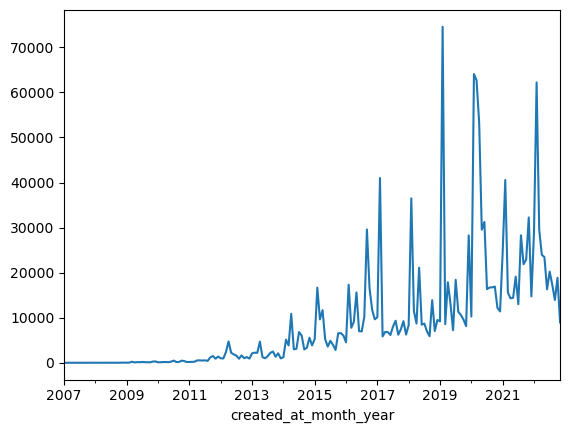

In [49]:
# How many Tweets in English are made about pangolins in each month/year?
df_eng_vol = english_tweets.groupby('created_at_month_year')['tweet'].count()
df_eng_vol.plot()

<AxesSubplot:xlabel='created_at_year'>

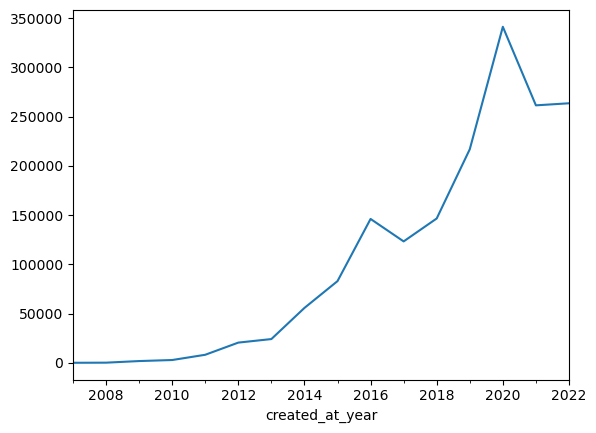

In [50]:
# Yearly aggregates to show trends
df_eng_vol2 = english_tweets.groupby('created_at_year')['tweet'].count()
df_eng_vol2.plot()

In [51]:
# Deepdive into top 15% prolific months/years
df_eng_vol.nlargest(10)

created_at_month_year
2019-02    74560
2020-02    64068
2020-03    62699
2022-02    62219
2020-04    53253
2017-02    41001
2021-02    40564
2018-02    36486
2021-11    32251
2020-06    31246
Freq: M, Name: tweet, dtype: int64

<AxesSubplot:xlabel='created_at_month_year'>

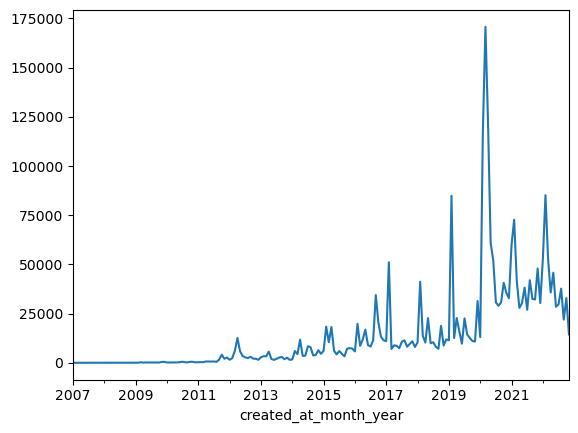

In [52]:
# How many Tweets in all languages are made about pangolins in each month/year?
df_vol = final_pangolin.groupby('created_at_month_year')['tweet'].count()
df_vol.plot()

<AxesSubplot:xlabel='created_at_year'>

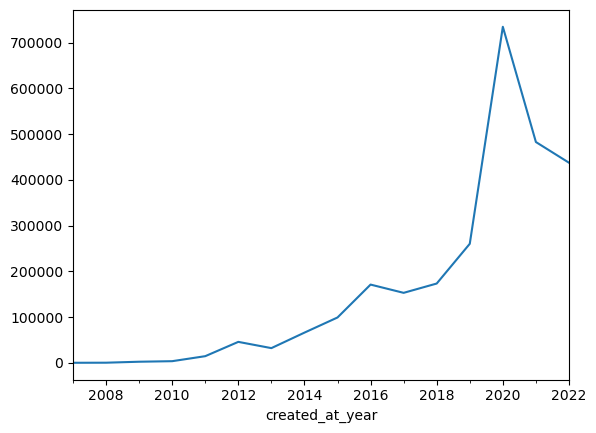

In [53]:
# Yearly aggregates to show trends
df_vol2 = final_pangolin.groupby('created_at_year')['tweet'].count()
df_vol2.plot()

In [54]:
# Deepdive into top 15% prolific months/years
df_vol.nlargest(10)

created_at_month_year
2020-03    170762
2020-04    121831
2020-02    116496
2022-02     85183
2019-02     84880
2021-02     72718
2020-05     60894
2021-01     59827
2022-01     52820
2022-03     52676
Freq: M, Name: tweet, dtype: int64

In [243]:
# What percentage of all tweets made in that month/year are about pangolins?


###### Language

In [55]:
# Tweet Volume by Language
df_lang = final_pangolin.groupby(['lang'])['lang'].count().nlargest(10)
df_lang

lang
en     1695541
fr      482282
es      272699
in       52824
tr       25278
ja       19601
qme      18983
zxx      13064
pt       11649
und      10770
Name: lang, dtype: int64

In [56]:
# Tweet Volume by Language/Year
df_lang2 = final_pangolin.groupby(['lang','created_at_year'])['lang'].count().nlargest(10)
df_lang2

lang  created_at_year
en    2020               341310
      2022               263607
      2021               261508
fr    2020               221200
en    2019               216905
      2018               146598
      2016               146125
fr    2021               129402
es    2020               123576
en    2017               123306
Name: lang, dtype: int64

###### Account Level

In [57]:
# How many unique accounts are posting about pangolins in English?
print(str(english_tweets['author_id'].nunique()) + " distinct Twitter users have made posts about pangolins in English.")
print("This is about " + str(round(english_tweets['author_id'].count()/english_tweets['author_id'].nunique(),2)) + " Tweets per user.")

682522 distinct Twitter users have made posts about pangolins in English.
This is about 2.48 Tweets per user.


created_at_year
2007         9
2008        62
2009      1114
2010      1766
2011      4715
2012     11740
2013     12944
2014     27789
2015     40693
2016     68904
2017     64038
2018     75717
2019    131809
2020    191531
2021    142563
2022     90483
Freq: A-DEC, Name: author_id, dtype: int64

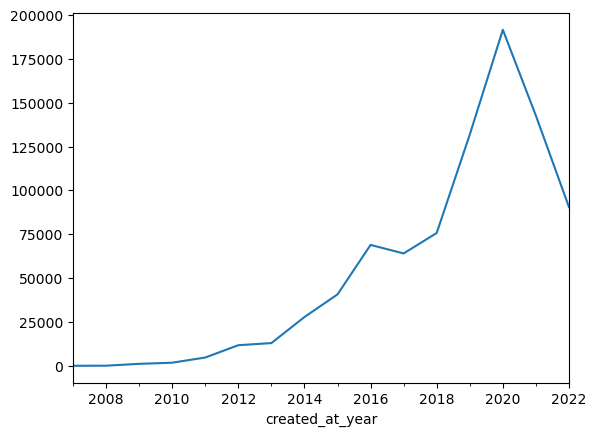

In [58]:
# How many accounts are posting about pangolins per Year in English?
groupings = english_tweets.groupby(['created_at_year']).nunique()
groupings = groupings['author_id']
groupings.plot()
groupings

<AxesSubplot:xlabel='year'>

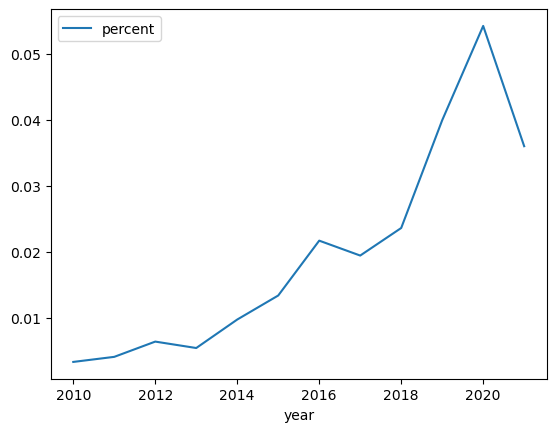

In [61]:
# What percentage of twitter users are tweeting about pangolins?
pd.concat([groupings, df_total_users])
year = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
perct_users_on_pang = [0.003261,0.00403,0.006346,0.005371,0.009694
                        ,0.013342,0.021668,0.019405,0.023588,0.039942,0.054258,0.036001]
df_acct_per = pd.DataFrame(np.column_stack([year,perct_users_on_pang]), columns=['year','percent'])
df_acct_per = df_acct_per.set_index('year')
df_acct_per.plot()

In [62]:
# How many posts are the authors making?
temp = english_tweets.groupby(['author_id'])['author_id'].count()
temp = temp.to_frame()
temp.columns = ['tweet_count']
temp.reset_index(inplace=True)
temp.describe()

,author_id,tweet_count
count,6.825220e+05,682522.000000
mean,3.787249e+17,2.484229
std,5.397690e+17,14.703094
min,2.910000e+02,1.000000
25%,2.662150e+08,1.000000
50%,2.235744e+09,1.000000
75%,9.023489e+17,2.000000
max,1.591456e+18,3624.000000


In [74]:
# What are the Twitter bios of the people making posts on pangolins? Filtering for only outlier accounts
outlier_accts = temp[temp['tweet_count']> (2 + (3))]
outlier_accts = outlier_accts.sort_values(by='tweet_count', ascending = False)
user_df = time_twitter_user_data(outlier_accts)
user_df

,id,username,description,location,created_at,public_metrics,verified
0,2189053751,kaatjeplanet5,,brabant,2013-11-20 16:23:04+00:00,"{'followers_count': 364, 'following_count': 569, 'tweet_count': 66054, 'listed_count': 75}",False
1,1883292865,Timelord30021,chaotic lego. whale facts salesperson. feed me pixels and ink.,Xalax,2013-09-19 14:03:59+00:00,"{'followers_count': 228, 'following_count': 2139, 'tweet_count': 46512, 'listed_count': 13}",False
2,1529281777,HiVoltWriter,Writes code sometimes. 007 fan. Loves the Fast & Furious movies unironically. A goddamn princess. This Is The Way. (He/Him) #AFoL #BlackLivesMatter 🇨🇦,Straight Outta Brampton,2013-06-19 00:53:49+00:00,"{'followers_count': 741, 'following_count': 2444, 'tweet_count': 57583, 'listed_count': 35}",False
3,817713067,PangolinSG,A global network of experts who are leading efforts to study and conserve the unique and fascinating pangolins.,Worldwide,2012-09-11 16:10:48+00:00,"{'followers_count': 7385, 'following_count': 881, 'tweet_count': 3213, 'listed_count': 115}",False
4,39222081,Nigeblue,"Bright, friendly, confident person. Bath Ales enthusiast. Living after cancer via an op. I enjoy visiting Dublin/Ireland, also an interest in wild tigers.","Bristol, England",2009-05-11 09:28:10+00:00,"{'followers_count': 1239, 'following_count': 451, 'tweet_count': 372942, 'listed_count': 419}",False
...,...,...,...,...,...,...,...
61,607265871,moijesuissympa,SG du SIFFAP CFDT #Syndicat des #Finances des #HautsdeFrance = #douanes #FinancesPubliques #CCRF-Labo #Insee #mines-tel #CRC #IRA #CDC #INPI #assistante soc …,"Lille, France",2012-06-13 12:50:51+00:00,"{'followers_count': 490, 'following_count': 1299, 'tweet_count': 28144, 'listed_count': 61}",False
62,1002977179502895104,karenjo99684113,,"Houston, TX",2018-06-02 18:16:08+00:00,"{'followers_count': 171, 'following_count': 629, 'tweet_count': 15911, 'listed_count': 1}",False
63,607283292,AbduLAleeGwarzo,HUSATAIN EMPIRE NIG LTD. abdulaig01@gmail.com,None,2012-06-13 13:14:45+00:00,"{'followers_count': 85, 'following_count': 41, 'tweet_count': 159958, 'listed_count': 35}",False
64,1002617783652438022,FrankSowa1,"Comprehensive Anticipatory Design Scientist, R&D Data Tech, Strategist, Futurist, Researcher, Writer, frmr Knight-Ridder&Dix journalist, veteran, dad, #DemVoice","Pittsburgh Area, Midwest, USA",2018-06-01 18:28:02+00:00,"{'followers_count': 10439, 'following_count': 7186, 'tweet_count': 352455, 'listed_count': 55}",False


In [105]:
batch_save(user_df,'user')

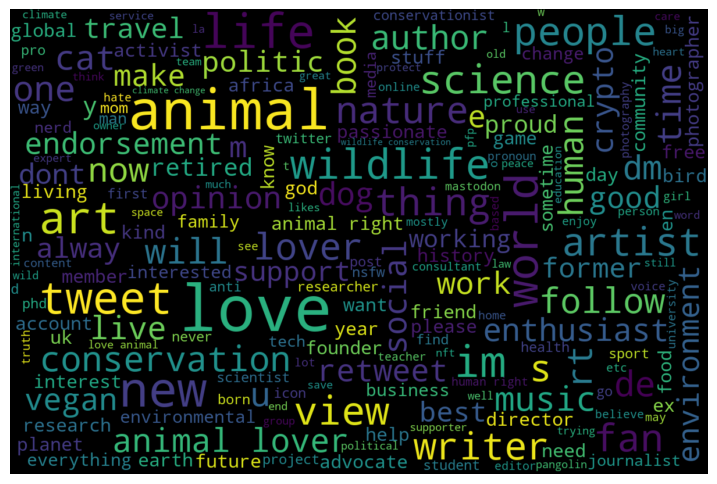

In [280]:
user_list = list(user_df["description"])
cleaned_user_list = [clean_tweet(tw) for tw in user_list]
all_words = ' '.join([text for text in cleaned_user_list])
wordcloud = WordCloud(width=1200, height=800, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(9, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

In [76]:
# LDA Topic Model on Bio
user_df["description_processed"] = user_df["description"].map(lambda x: re.sub('[,\.!?]', '', x))
user_df["description_processed"] = user_df["description_processed"].map(lambda x: re.sub("@[A-Za-z0-9_]+","", x))
user_df["description_processed"] = user_df["description_processed"].map(lambda x: re.sub("#[A-Za-z0-9_]+","", x))
user_df['description_processed'] = user_df["description_processed"].map(lambda x: re.sub(r'http\S+', '', x))
user_df['description_processed'] = user_df["description_processed"].map(lambda x: re.sub("'", "", x))
user_df['description_processed'] = user_df["description_processed"].map(lambda x: x.lower())
user_df.head(5)

,id,username,description,location,created_at,public_metrics,verified,description_processed
0,2189053751,kaatjeplanet5,,brabant,2013-11-20 16:23:04+00:00,"{'followers_count': 364, 'following_count': 569, 'tweet_count': 66054, 'listed_count': 75}",False,
1,1883292865,Timelord30021,chaotic lego. whale facts salesperson. feed me pixels and ink.,Xalax,2013-09-19 14:03:59+00:00,"{'followers_count': 228, 'following_count': 2139, 'tweet_count': 46512, 'listed_count': 13}",False,chaotic lego whale facts salesperson feed me pixels and ink
2,1529281777,HiVoltWriter,Writes code sometimes. 007 fan. Loves the Fast & Furious movies unironically. A goddamn princess. This Is The Way. (He/Him) #AFoL #BlackLivesMatter 🇨🇦,Straight Outta Brampton,2013-06-19 00:53:49+00:00,"{'followers_count': 741, 'following_count': 2444, 'tweet_count': 57583, 'listed_count': 35}",False,writes code sometimes 007 fan loves the fast & furious movies unironically a goddamn princess this is the way (he/him) 🇨🇦
3,817713067,PangolinSG,A global network of experts who are leading efforts to study and conserve the unique and fascinating pangolins.,Worldwide,2012-09-11 16:10:48+00:00,"{'followers_count': 7385, 'following_count': 881, 'tweet_count': 3213, 'listed_count': 115}",False,a global network of experts who are leading efforts to study and conserve the unique and fascinating pangolins
4,39222081,Nigeblue,"Bright, friendly, confident person. Bath Ales enthusiast. Living after cancer via an op. I enjoy visiting Dublin/Ireland, also an interest in wild tigers.","Bristol, England",2009-05-11 09:28:10+00:00,"{'followers_count': 1239, 'following_count': 451, 'tweet_count': 372942, 'listed_count': 419}",False,bright friendly confident person bath ales enthusiast living after cancer via an op i enjoy visiting dublin/ireland also an interest in wild tigers


In [77]:
stop_words = stopwords.words('english')
stop_words.extend(['rt','png','also'])

# Convert Tweets into Words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Function to remove stop words from Tweets
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

# Call functions on cleaned english_tweet data
data = user_df.description_processed.values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

In [78]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [79]:
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [80]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [81]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [100]:
# Run the LDA Model using the optimal values from the hyper-parameter tuning section
lda_model_user = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha = 0.91,
                                       eta = 0.91,
                                       per_word_topics=True)

In [103]:
# Visualize the topics using the most optimal model from previous cell
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_user, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.153329  0.026076       1        1  26.600732
2      0.069432  0.104392       2        1  22.286991
1      0.019678 -0.081566       3        1  19.605628
0      0.030329 -0.003428       4        1  15.952422
4      0.033889 -0.045473       5        1  15.554227, topic_info=              Term         Freq        Total Category  logprob  loglift
97          animal  2472.000000  2472.000000  Default  30.0000  30.0000
10            love  1548.000000  1548.000000  Default  29.0000  29.0000
249           news   737.000000   737.000000  Default  28.0000  28.0000
61    conservation   816.000000   816.000000  Default  27.0000  27.0000
148          tweet   616.000000   616.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
803         editor    49.121148   123.208432   Topic5  -6.5365   0.9412
1462          self    40.513500    70.144755   Topic5  -6.7292   1.3119
322             go    53.537920   279.552179   Topic5  -6.4504   0.2080
473       director    46.438921   172.065817   Topic5  -6.5927   0.5511
1223        member    46.599750   199.900201   Topic5  -6.5892   0.4046

[323 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
127       1  0.974625  abuse
127       2  0.009109  abuse
127       3  0.009109  abuse
127       4  0.009109  abuse
127       5  0.009109  abuse
...     ...       ...    ...
209       1  0.267830   year
209       2  0.224103   year
209       3  0.076523   year
209       4  0.388081   year
209       5  0.043727   year

[1370 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1, 5])

/opt/anaconda3/envs/pangolin_twitter/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/pangolin_twitter/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/envs/pangolin_twitter/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/envs/pangolin_twitter/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/envs/pangolin_twitter/lib/python3.7/site-packages/setuptools/_dist

In [89]:
#Hyper-parameter tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model_user = gensim.models.LdaMulticore(corpus=gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True,
                                           alpha = a,
                                           eta = b
                                          )
    
    coherence_model_lda = CoherenceModel(model=lda_model_user, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [95]:
grid = {}
grid['Validation_Set'] = {}

# Topics Range
min_topics = 14
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha Parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta Parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation Sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Setup Tracker - Will take ~24 hrs to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                      k=k, a=a, b=b)
            # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)
    pd.DataFrame(model_results)
    pbar.close()

model_results = pd.DataFrame(model_results)
model_results.sort_values('Coherence', ascending = False)

100%|███████████████████████████████████████| 360/360 [2:46:18<00:00, 27.72s/it]


,Validation_Set,Topics,Alpha,Beta,Coherence
258,100% Corpus,16,0.91,0.91,-3.504184
288,100% Corpus,17,0.91,0.91,-3.510463
168,75% Corpus,19,0.91,0.91,-3.510901
348,100% Corpus,19,0.91,0.91,-3.511103
48,75% Corpus,15,0.91,0.91,-3.511189
...,...,...,...,...,...
238,100% Corpus,15,asymmetric,0.91,-16.656315
358,100% Corpus,19,asymmetric,0.91,-16.703175
268,100% Corpus,16,asymmetric,0.91,-16.836279
88,75% Corpus,16,asymmetric,0.91,-16.994063


### Word Cloud Generation

We will create a word cloud of the common words found in Tweets referencing "pangolins". Not only does this provide a visual of our dataset, but it will serve as a method of verification for our topic modeling.

In [272]:
# Only pull Tweets written in English
tweet_list = list(english_tweets["tweet"])

In [273]:
# Remove profanity, stop words, and standardize text structure
def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    r = tweet.lower()                       # Make entire tweet lowercase
    r = re.sub("'", "", r)                  # Remove apostrophes in contractions
    r = re.sub("@[A-Za-z0-9_]+","", r)      # Remove mentions
    r = re.sub("#[A-Za-z0-9_]+","", r)      # Remove hashtags
    r = re.sub(r'http\S+', '', r)           # Remove links
    r = re.sub('[()!?]', ' ', r)            # Remove punctuation
    r = re.sub('\[.*?\]',' ', r)            # Remove punctuation
    r = re.sub("[^a-z0-9]"," ", r)          # Removes other non-alphanumeric characters
    r = r.split()                           # Separate words in tweet to remove below stopwords
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
    r = [w for w in r if not w in stopwords]
    r = " ".join(word for word in r)
    return r

# Return cleaned tweet list
cleaned = [clean_tweet(tw) for tw in tweet_list]

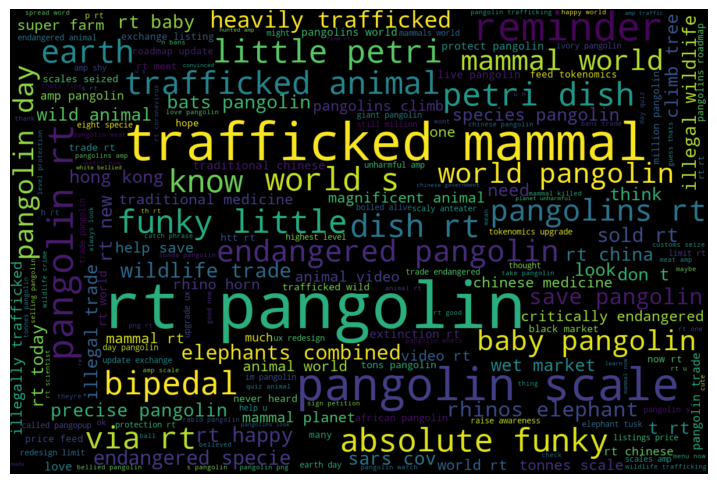

In [10]:
# Create word cloud of Tweet data
all_words = ' '.join([text for text in cleaned])
wordcloud = WordCloud(width=1200, height=800, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(9, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

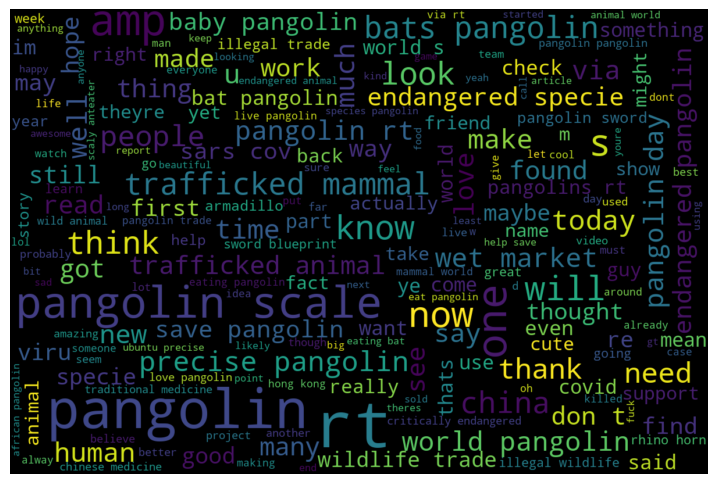

In [11]:
# Create word cloud of distinct Tweets (excluding Quotes and Retweets)
distinct_cleaned = [*set(cleaned)]
all_words = ' '.join([text for text in distinct_cleaned])
wordcloud = WordCloud(width=1200, height=800, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(9, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

### DEPRECATED: Tweet Topics

https://www.databricks.com/de/wp-content/uploads/notebooks/new-year-sql/02-categorizing-tweets-and-populating-resultst-to-gold-table.html

In [ ]:
# What are target words describing conservation?
conserve_words = ['scales','extinction','traffickers','trafficked', 'mammal', 'endangered','species', 'scale']
non_conserve_words = []
conserve_pattern = '|'.join([f'(?i){word}' for word in conserve_words])

# Cast to date for visualizaiton puposes
df['created_at_date'] = df['created_at'].dt.date

# Determine if tweet contains conservation vocabulary
df['contains_conserve'] = df['tweets'].str.contains(conserve_pattern)
df

In [ ]:
def get_most_sim(list_tokens):
    words = glove_vectors.most_similar(positive = list_tokens, topn = 20)
    words = [t[0] for t in words if t[1] > .85]
    return words

In [ ]:
topic_dict = {"virus": ['covid', 'sickness', 'illness', 'pandemic',''], 
              "gaming": ['', ''], 
              "conservation": ['conserve', 'trafficked','trafficking',''],
              "medicine": ['traditional', 'alternative',''],
            }

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(["", ""])
 
for key in topic_dict:
    temp_list = topic_dict[key]
    temp_list.extend(get_most_sim(topic_dict[key]))
    temp_list = [t for t in temp_list if not t.lower() in stop_words]
    topic_dict[key] = temp_list

### Topic Modeling with Latent Dirichlet Allocation (LDA)

https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Evaluate%20Topic%20Models.ipynb

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [8]:
# For topic modeling, we are only interested in the columns with the textual data
english_tweets = final_pangolin.loc[final_pangolin['lang'] == 'en']
english_tweets = english_tweets.reset_index(drop=True)
english_tweets_text = english_tweets.drop(columns=['tweet_id', 'author_id', 'lang','created_at'], axis=1)

In [9]:
# Clean and standardize the textual data in the tweets
english_tweets_text['tweet_processed'] = english_tweets_text['tweet'].map(lambda x: re.sub('[,\.!?]', '', x))
english_tweets_text['tweet_processed'] = english_tweets_text['tweet_processed'].map(lambda x: re.sub("@[A-Za-z0-9_]+","", x))
english_tweets_text['tweet_processed'] = english_tweets_text['tweet_processed'].map(lambda x: re.sub("#[A-Za-z0-9_]+","", x))
english_tweets_text['tweet_processed'] = english_tweets_text['tweet_processed'].map(lambda x: re.sub(r'http\S+', '', x))
english_tweets_text['tweet_processed'] = english_tweets_text['tweet_processed'].map(lambda x: re.sub("'", "", x))
english_tweets_text['tweet_processed'] = english_tweets_text['tweet_processed'].map(lambda x: x.lower())
english_tweets_text.head(5)

,tweet,created_at_date,created_at_month_year,created_at_year,tweet_processed
0,I'm a pangolin! What's your Earth Day #GoogleDoodle quiz animal? https://t.co/9wvHLvnzhX,2015-04-22,2015-04,2015,im a pangolin whats your earth day quiz animal
1,I'm a pangolin! What's your Earth Day #GoogleDoodle quiz animal? https://t.co/GXOOfYfmnd,2015-04-22,2015-04,2015,im a pangolin whats your earth day quiz animal
2,I'm a pangolin! What's your Earth Day #GoogleDoodle quiz animal? https://t.co/yeAIpYi5Ws,2015-04-22,2015-04,2015,im a pangolin whats your earth day quiz animal
3,I'm a pangolin! What's your Earth Day #GoogleDoodle quiz animal? https://t.co/dgaX2qQPOX,2015-04-22,2015-04,2015,im a pangolin whats your earth day quiz animal
4,I'm a pangolin! What's your Earth Day #GoogleDoodle quiz animal? https://t.co/mJygDs48Pq hmmm,2015-04-22,2015-04,2015,im a pangolin whats your earth day quiz animal hmmm


In [10]:
# Import english stop words and add common words from word cloud that aren't important
stop_words = stopwords.words('english')
stop_words.extend(['rt','png','also'])

# Convert Tweets into Words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Function to remove stop words from Tweets
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

# Call functions on cleaned english_tweet data
data = english_tweets_text.tweet_processed.values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [15]:
# Run the LDA Model using the optimal values from the hyper-parameter tuning section
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=2, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha = 0.1,
                                       eta = 0.61,
                                       per_word_topics=True)

In [16]:
# Print the words that commonly make up each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.080*"pangolin" + 0.014*"scale" + 0.012*"bat" + 0.011*"little" + '
  '0.010*"earth" + 0.010*"reminder" + 0.010*"bipedal" + 0.010*"dish" + '
  '0.010*"absolute" + 0.010*"funky"'),
 (1,
  '0.098*"pangolin" + 0.039*"world" + 0.037*"traffic" + 0.031*"mammal" + '
  '0.028*"animal" + 0.020*"scale" + 0.018*"specie" + 0.018*"endanger" + '
  '0.018*"trafficked" + 0.015*"trade"')]


##### Hyper-Parameter Tuning

https://stackoverflow.com/questions/54762690/evaluation-of-topic-modeling-how-to-understand-a-coherence-value-c-v-of-0-4

In [ ]:
# Initial Results with Alpha & Beta Consistent - will move forward wiht lower topic counts.
pd.DataFrame(model_results)

In [ ]:
# We will call this function based on the alpha, beta, and number of topics we are testing
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True,
                                           alpha = a,
                                           eta = b
                                          )
    
    coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=data_lemmatized, 
                                         dictionary=id2word, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# Define topic counts, corpus length, alpha, and beta values we want to test
grid = {}
grid['Validation_Set'] = {}

# Topics Range
min_topics = 2
max_topics = 4
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha Parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta Parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation Sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Setup Tracker - Will take ~24 hrs to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                      k=k, a=a, b=b)
            # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)
    pd.DataFrame(model_results)
    pbar.close()

In [ ]:
# Visualize the results ordered by the highest coherence value
model_results = pd.DataFrame(model_results)
model_results.sort_values('Coherence', ascending = False)

In [17]:
# Visualize the topics using the most optimal model from previous cell
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.193839  0.0       1        1  68.301413
1     -0.193839  0.0       2        1  31.698587, topic_info=          Term           Freq          Total Category  logprob  loglift
306      world  143681.000000  143681.000000  Default  30.0000  30.0000
262    traffic  135428.000000  135428.000000  Default  29.0000  29.0000
460     mammal  113309.000000  113309.000000  Default  28.0000  28.0000
4     pangolin  995849.000000  995849.000000  Default  27.0000  27.0000
0       animal  158903.000000  158903.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
331        amp   36391.941275   77050.020801   Topic2  -4.6203   0.3988
1          day   25359.779219   44040.449879   Topic2  -4.9815   0.5970
4144  reminder   32730.938505  109424.131209   Topic2  -4.7263  -0.0580
402   wildlife   22892.684330   73700.943686   Topic2  -5.0838  -0.0203
161     people   21716.480057   50741.629761   Topic2  -5.1366   0.3002

[131 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3439      1  0.999993  absolute
3439      2  0.000013  absolute
331       1  0.527683       amp
331       2  0.472317       amp
0         1  0.345292    animal
...     ...       ...       ...
473       2  0.637037      wild
402       1  0.689381  wildlife
402       2  0.310620  wildlife
306       1  0.000007     world
306       2  0.999993     world

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [18]:
def format_topics_sentences(lda_model=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(lda_model[corpus]):
        row = row_list[0] if lda_model.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(lda_model=lda_model, corpus=corpus, texts=texts)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

/opt/anaconda3/envs/pangolin_twitter/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/pangolin_twitter/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/envs/pangolin_twitter/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/opt/anaconda3/envs/pangolin_twitter/lib/python3.7/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/opt/anaconda3/envs/pangolin_twitter/lib/python3.7/site-packages/setuptools/_dist

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9861,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[m, pangolin, s, earth, day, quiz, animal]"
1,1,1.0,0.9861,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[m, pangolin, s, earth, day, quiz, animal]"
2,2,1.0,0.9861,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[m, pangolin, s, earth, day, quiz, animal]"
3,3,1.0,0.9861,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[m, pangolin, s, earth, day, quiz, animal]"
4,4,1.0,0.6803,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[m, pangolin, s, earth, day, quiz, animal, hmmm]"
...,...,...,...,...,...
1695536,1695536,0.0,0.9934,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[flutter, wing, cause, know, however, guy, eat, cause, shortage, pasta, toilet, paper, supermarket, card, shuffle]"
1695537,1695537,0.0,0.9808,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[large, pangolin, extend_tongue, much, cm]"
1695538,1695538,0.0,0.9839,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[ever, fry, almost, good, bat, soup]"
1695539,1695539,0.0,0.9545,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[agree, pangolin]"


In [20]:
df_dominant_topic.to_csv(index=False)

In [30]:
output_path = '/Users/hannahmurray/Desktop/pangolin_twitter_data_files/dominant_topics'
batch_save(df_dominant_topic, f'{output_path}/dominant_topic')

In [31]:
num_rows = 0
for i in range(17):
    temp_df = pd.read_csv(f'{output_path}/dominant_topic_{i}.csv')
    num_rows += len(temp_df)
num_rows

1695541

In [34]:
# Topic 1 Subset: Traffic, trade, endanger (protection)
df_topic_one = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1.0]
df_topic_one

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9861,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[m, pangolin, s, earth, day, quiz, animal]"
1,1,1.0,0.9861,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[m, pangolin, s, earth, day, quiz, animal]"
2,2,1.0,0.9861,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[m, pangolin, s, earth, day, quiz, animal]"
3,3,1.0,0.9861,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[m, pangolin, s, earth, day, quiz, animal]"
4,4,1.0,0.6803,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[m, pangolin, s, earth, day, quiz, animal, hmmm]"
...,...,...,...,...,...
1695458,1695458,1.0,0.9545,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[save, pangolin]"
1695460,1695460,1.0,0.9545,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[plight, traffic]"
1695471,1695471,1.0,0.9861,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[pangolin, traffic, mammal, ve, never, hear, national]"
1695508,1695508,1.0,0.9671,"pangolin, world, traffic, mammal, animal, scale, specie, endanger, trafficked, trade","[get, guappe, watch]"


In [35]:
# Topic 2 Subset: Earth, Good, 
df_topic_zero = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0.0]
df_topic_zero

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
21,21,0.0,0.9714,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[m, pangolin, fuckall, question]"
23,23,0.0,0.9687,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[clearly, base, answer]"
31,31,0.0,0.5000,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky",[]
39,39,0.0,0.9762,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[m, actually, pangolin, well]"
58,58,0.0,0.6710,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[m, think, actually, quite, accurate, s, quiz, animal]"
...,...,...,...,...,...
1695536,1695536,0.0,0.9934,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[flutter, wing, cause, know, however, guy, eat, cause, shortage, pasta, toilet, paper, supermarket, card, shuffle]"
1695537,1695537,0.0,0.9808,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[large, pangolin, extend_tongue, much, cm]"
1695538,1695538,0.0,0.9839,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[ever, fry, almost, good, bat, soup]"
1695539,1695539,0.0,0.9545,"pangolin, scale, bat, little, earth, reminder, bipedal, dish, absolute, funky","[agree, pangolin]"


### What's Next?

### Sentiment Analysis

In [274]:
sentiment_objects = [TextBlob(tweet) for tweet in cleaned]

In [275]:
# Define sentiment for all other Tweets
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

In [276]:
# Input list sentiment data as Pandas dataframe
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])
sentiment_df

,polarity,tweet
0,0.000000,im pangolin whats your earth day quiz animal
1,0.000000,im pangolin whats your earth day quiz animal
2,0.000000,im pangolin whats your earth day quiz animal
3,0.000000,im pangolin whats your earth day quiz animal
4,0.000000,im pangolin whats your earth day quiz animal hmmm
...,...,...
1695536,-0.033333,can flutter butterflys wings brazil cause tornado texas i dont know however guy who eats pangolin wuhan can cause shortage pasta toilet paper our supermarkets cards are shuffled
1695537,0.138095,rt large pangolins can extend their tongues as much as 40 cm with diameter only 0 5 cm
1695538,0.850000,have you ever had fried pangolin its delicious almost as good as bat soup
1695539,-0.500000,agreed but wtf pangolin


In [277]:
# Save the polarity column as 'n'.
n = sentiment_df["polarity"]

# Convert this column into a series, 'm'. 
m = pd.Series(n)

In [278]:
# Initialize Positive, Negative, and Neutral Counts
pos=0
neg=0
neu=0

# Create loop to classify Tweets as Positive, Negative, or Neutral and gather counts
for items in m:
    if items>0:
        pos=pos+1
    elif items<0:
        neg=neg+1
    else:
        neu=neu+1

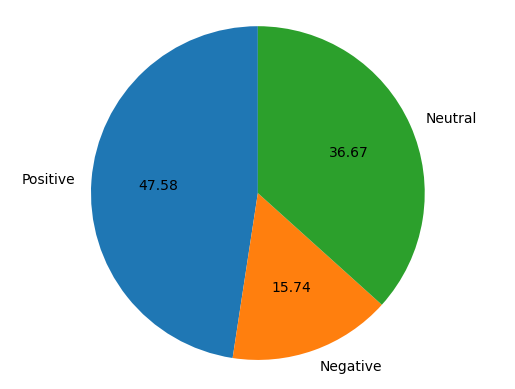

In [279]:
# View pos, neg, and neu values in chart
pieLabels=["Positive","Negative","Neutral"]
populationShare=[pos,neg,neu]

figureObject, axesObject = plt.subplots()
axesObject.pie(populationShare,labels=pieLabels,autopct='%1.2f',startangle=90)
axesObject.axis('equal')

plt.show()